In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import asarray
from PIL import Image
import pathlib
import os
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
from torchvision.transforms import v2
import seaborn as sns
from sklearn.manifold import TSNE

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
# Hyper-parameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

#Model Parameters
num_features = 11

In [33]:
dataset_dir=pathlib.Path("/Users/karthikd1054/Documents/COMP 6721/Project/plant_leaf_dataset/dataset2")
dataset = ImageFolder(root="/Users/karthikd1054/Documents/COMP 6721/Project/plant_leaf_dataset/dataset2", transform=transforms.Compose([ToTensor(), transforms.Resize((224, 224))]))

dataset_dict={
    'Mango': list(dataset_dir.glob('Mango (P0)/*.JPG')),
    'Arjun': list(dataset_dir.glob('Arjun (P1)/*.JPG')),
    'Alstonia_Scholaris': list(dataset_dir.glob('Alstonia Scholaris (P2)/*.JPG')),
    'Gauva': list(dataset_dir.glob('Gauva (P3)/*.JPG')),
    'Jamun': list(dataset_dir.glob('Jamun (P5)/*.JPG')),
    'Jatropha':list(dataset_dir.glob('Jatropha (P6)/*.JPG')),
    'Pongamia_Pinnata':list(dataset_dir.glob('Pongamia Pinnata (P7)/*.JPG')),
    'Basil':list(dataset_dir.glob('Basil (P8)/*.JPG')),
    'Pomegranate':list(dataset_dir.glob('Pomegranate (P9)/*.JPG')),
    'Lemon':list(dataset_dir.glob('Lemon (P10)/*.JPG')),
    'Chinar':list(dataset_dir.glob('Chinar (P11)/*.JPG')),
}

class_label_dict={
    'Mango':0,
    'Arjun':1,
    'Alstonia_Scholaris':2,
    'Gauva':3,
    'Jamun':4,
    'Jatropha':5,
    'Pongamia_Pinnata':6,
    'Basil':7,
    'Pomegranate':8,
    'Lemon':9,
    'Chinar':10,
}

In [34]:
affine_image = v2.Compose([
    v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
])
random_zoom=v2.Compose([
    v2.RandomResizedCrop(size=(224, 224))
])
rotation=v2.Compose([
    v2.RandomRotation(degrees=(0, 180))
])
auto_contrast=v2.Compose([
  v2.RandomAutocontrast(0.5)
])

X=[]
y=[]
count=0
for key in dataset_dict.keys():
  for values in dataset_dict[key]:
        resized_image=Image.open(values).resize((224,224))
        X.append(resized_image)
        y.append(class_label_dict[key])
        affined_image=affine_image(resized_image)
        X.append(affined_image)
        y.append(class_label_dict[key])
        zoomed_image=random_zoom(resized_image)
        X.append(zoomed_image)
        y.append(class_label_dict[key])
        rotated_image=rotation(resized_image)
        X.append(rotated_image)
        y.append(class_label_dict[key])
        contrast_image=auto_contrast(resized_image)
        X.append(contrast_image)
        y.append(class_label_dict[key])
        count+=1
        if (count%100==0):
          print(f"{count} images added to the list")

100 images added to the list
200 images added to the list
300 images added to the list
400 images added to the list
500 images added to the list
600 images added to the list
700 images added to the list
800 images added to the list
900 images added to the list
1000 images added to the list
1100 images added to the list
1200 images added to the list
1300 images added to the list
1400 images added to the list
1500 images added to the list
1600 images added to the list
1700 images added to the list
1800 images added to the list
1900 images added to the list
2000 images added to the list
2100 images added to the list
2200 images added to the list


In [60]:
(X_train,X_test,y_train,y_test)=train_test_split(X,y,test_size=0.2,random_state=0)

In [68]:
#Making the dataset ready for taining out of x_train and y_train

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2572, 0.2816, 0.2473],
                         std=[0.3007, 0.3072, 0.2996])
])

# Create your Dataset
dataset = CustomDataset(images=X, labels=y, transform=transform)

In [66]:
print(X_train)

[<PIL.Image.Image image mode=RGB size=224x224 at 0x332053160>, <PIL.Image.Image image mode=RGB size=224x224 at 0x3247B24F0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x322867C10>, <PIL.Image.Image image mode=RGB size=224x224 at 0x3227A3B80>, <PIL.Image.Image image mode=RGB size=224x224 at 0x331F8A0D0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x33216B280>, <PIL.Image.Image image mode=RGB size=224x224 at 0x3014A0130>, <PIL.Image.Image image mode=RGB size=224x224 at 0x331EA8850>, <PIL.Image.Image image mode=RGB size=224x224 at 0x3227D3C40>, <PIL.Image.Image image mode=RGB size=224x224 at 0x332099F10>, <PIL.Image.Image image mode=RGB size=224x224 at 0x301513160>, <PIL.Image.Image image mode=RGB size=224x224 at 0x3015062E0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x3321F48E0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x332109B50>, <PIL.Image.Image image mode=RGB size=224x224 at 0x33201D430>, <PIL.Image.Image image mode=RGB size=224x224 at 0x332053820>, <PIL.Im

In [69]:
dataset, testDataset=torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - (int(0.9 * len(dataset)))])
trainDataset, validationDataset = torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - (int(0.9 * len(dataset)))])



trainingDataLoader = DataLoader(
    trainDataset,
    batch_size=batch_size,
    shuffle=True
)

validationDataLoader = DataLoader(
    validationDataset,
    batch_size=batch_size,
    shuffle=False
)

testingDataLoader = DataLoader(
    testDataset,
    batch_size=batch_size,
    shuffle=False
)

#Write code to display the images in each dataloader

In [76]:
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_features)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [77]:
print(device)

mps


In [78]:
total_steps = len(trainingDataLoader)

batchwiseTrainAccuracyLog = []
batchwiseTrainLossLog = []

epochwiseTrainAccuracyLog = []
epochwiseTrainLossLog = []

batchwiseValAccuracyLog = []
batchwiseValLossLog = []

epochwiseValAccuracyLog = []
epochwiseValLossLog = []

for epoch in range(num_epochs):

    total_label_count = 0

    accumulated_train_loss=0
    accumulated_validation_loss=0

    accumulated_train_accuracy=0
    accumulated_validation_accuracy=0

    inner_loop_counter_train=0
    model.train()
    for i, data in enumerate(trainingDataLoader):
        inner_loop_counter_train+=1

        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_label_count += labels.size(0)
        accumulated_train_accuracy += (predicted == labels).sum().item()
        accumulated_train_loss+=loss.item()
        if (i + 10) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.7f}, Accuracy: {:.4f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            batchwiseTrainAccuracyLog.append((correct / total) * 100)
            batchwiseTrainLossLog.append(loss.item())
    training_accuracy = accumulated_train_accuracy / total_label_count
    epochwiseTrainAccuracyLog.append(training_accuracy)
    print(f'EPOCH {epoch + 1}.....................')
    print('Accuracy on training set: {}%'.format(100 * training_accuracy))
    epochwiseTrainLossLog.append(accumulated_train_loss/inner_loop_counter_train)

    #Evaluation using validation data

    total_label_count = 0

    inner_loop_counter_validation=0

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(validationDataLoader):
        inner_loop_counter_validation+=1

        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accumulated_validation_accuracy += (predicted == labels).sum().item()
        total_label_count += labels.size(0)
        accumulated_validation_loss+=loss.item()
        if (i + 1) % 10 == 0:
            batchwiseValAccuracyLog.append((correct / total) * 100)
            batchwiseValLossLog.append(loss.item())
    validation_accuracy = accumulated_validation_accuracy / total_label_count
    epochwiseValAccuracyLog.append(validation_accuracy)
    print('Accuracy on validation set: {}%'.format(100 * validation_accuracy))
    epochwiseValLossLog.append(accumulated_validation_loss/inner_loop_counter_validation)
print("Training Finished!")


Epoch [1/20], Step [1/289], Loss: 2.4150989, Accuracy: 9.3750%
Epoch [1/20], Step [11/289], Loss: 2.4062715, Accuracy: 9.3750%
Epoch [1/20], Step [21/289], Loss: 2.3276336, Accuracy: 6.2500%
Epoch [1/20], Step [31/289], Loss: 2.3142905, Accuracy: 9.3750%
Epoch [1/20], Step [41/289], Loss: 2.3152733, Accuracy: 18.7500%
Epoch [1/20], Step [51/289], Loss: 2.3233612, Accuracy: 18.7500%
Epoch [1/20], Step [61/289], Loss: 2.2082181, Accuracy: 21.8750%
Epoch [1/20], Step [71/289], Loss: 2.1929612, Accuracy: 21.8750%
Epoch [1/20], Step [81/289], Loss: 2.1925950, Accuracy: 25.0000%
Epoch [1/20], Step [91/289], Loss: 2.1381414, Accuracy: 31.2500%
Epoch [1/20], Step [101/289], Loss: 2.1747906, Accuracy: 28.1250%
Epoch [1/20], Step [111/289], Loss: 2.0883129, Accuracy: 25.0000%
Epoch [1/20], Step [121/289], Loss: 2.2129760, Accuracy: 28.1250%
Epoch [1/20], Step [131/289], Loss: 2.2623763, Accuracy: 12.5000%
Epoch [1/20], Step [141/289], Loss: 2.2863755, Accuracy: 25.0000%
Epoch [1/20], Step [151/2

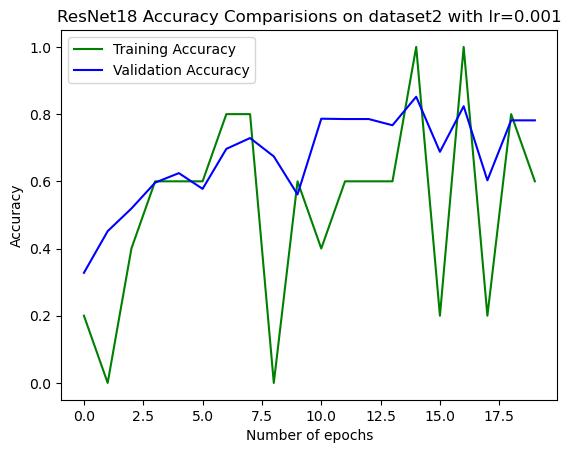

In [79]:
fig,ax=plt.subplots()
epochs_list = list(range(0,20))
ax.plot(epochs_list,epochwiseTrainAccuracyLog,'g',label='Training Accuracy')
ax.plot(epochs_list,epochwiseValAccuracyLog,'b',label='Validation Accuracy')
ax.plot()
ax.set_title('ResNet18 Accuracy Comparisions on dataset2 with lr=0.001')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

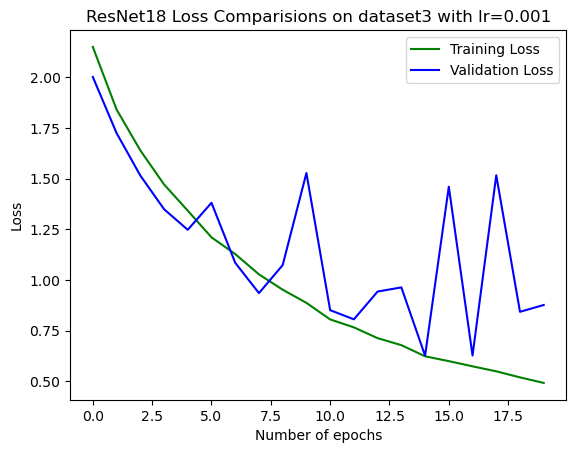

In [80]:
fig,ax=plt.subplots()
ax.plot(epochs_list,epochwiseTrainLossLog,'g',label='Training Loss')
ax.plot(epochs_list,epochwiseValLossLog,'b',label='Validation Loss')
ax.plot()
ax.set_title('ResNet18 Loss Comparisions on dataset3 with lr=0.001')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [81]:
y_pred = []
groundtruth = []

model.eval()

testAccuracyLog = []
testLossLog = []

with torch.no_grad():

    inner_loop_counter_test = 0

    accumulated_test_accuracy=0
    accumulated_test_loss=0

    for images, labels in testingDataLoader:
        images = images.to(device)
        labels = labels.to(device)
        inner_loop_counter_test+=1
        test_loss=0
        outputs = model(images)
        test_loss=criterion(outputs,labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.append(predicted)
        groundtruth.append(labels)
        accumulated_test_loss+=test_loss.item()
    testLossLog.append(accumulated_test_loss/inner_loop_counter_test)
    test_accuracy=correct/total
    print('Accuracy on test set: {}%'.format(100 * test_accuracy))
    testAccuracyLog.append(test_accuracy)

predictions_np = [tensor.detach().cpu().numpy() for tensor in y_pred]
ground_truth_np = [tensor.detach().cpu().numpy() for tensor in groundtruth]

predictions_np = np.concatenate(predictions_np)
ground_truth_np = np.concatenate(ground_truth_np)

accuracy = accuracy_score(ground_truth_np, predictions_np)
recall = recall_score(ground_truth_np, predictions_np, average='weighted')
conf_matrix = confusion_matrix(ground_truth_np, predictions_np)
f_score = f1_score(ground_truth_np, predictions_np, average='weighted')

print("Dataset 2 - Test Metrics\nAccuracy:", accuracy*100)
print("Recall:", recall*100)
print("F-score:", f_score*100)

print("Confusion Matrix:")

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix ResNet18 on Dataset2 lr=0.001')
plt.show()

Accuracy on test set: 75.26315789473685%
Dataset 2 - Test Metrics
Accuracy: 75.32923617208077
Recall: 75.32923617208077
F-score: 75.41245839278267
Confusion Matrix:


NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>